In [ ]:
# %load user_paths.py
LOCAL_USER_TRAIN_DIR = '/Users/justinmendiguarin/Desktop/Vehicle_Image_Classification/train'
LOCAL_USER_TEST_DIR = '/Users/justinmendiguarin/Desktop/Vehicle_Image_Classification/test'


In [21]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = LOCAL_USER_TRAIN_DIR
TEST_DIR = LOCAL_USER_TEST_DIR

# Try experimenting with img size
IMG_SIZE = 50

#Learning Rate
LR = 1e-3 

MODEL_NAME = 'vehicles-{}-{}.mode'.format(LR, '6conv-basic-video')

In [22]:
def get_label_array(vehicle_type):
    switcher = {
        'articulated_truck': [1,0,0,0,0,0,0,0,0,0,0],
        'background': [0,1,0,0,0,0,0,0,0,0,0],
        'bicycle': [0,0,1,0,0,0,0,0,0,0,0],
        'bus': [0,0,0,1,0,0,0,0,0,0,0],
        'car': [0,0,0,0,1,0,0,0,0,0,0],
        'motorcycle': [0,0,0,0,0,1,0,0,0,0,0],
        'non-motorized_vehicle': [0,0,0,0,0,0,1,0,0,0,0],
        'pedestrian': [0,0,0,0,0,0,0,1,0,0,0],
        'pickup_truck': [0,0,0,0,0,0,0,0,1,0,0],
        'single_unit_truck': [0,0,0,0,0,0,0,0,0,1,0],
        'work_van': [0,0,0,0,0,0,0,0,0,0,1],
        
    }
    return switcher.get(vehicle_type, "nothing")
            

In [23]:
def create_train_data():
    training_data = []
    for folder in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR,folder)
        if(not folder.startswith(".") and os.path.isdir(path)): 
            vehicle_type = os.path.basename(path)
            label_array = get_label_array(vehicle_type)
            #print(vehicle_type)
        
            for img in os.listdir(path):
                img_path = os.path.join(path,img)              
                img = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
                training_data.append([np.array(img), np.array(label_array)])
    
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [24]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])

    np.save('test_data.npy', testing_data)
    return testing_data

In [25]:
train_data = create_train_data()
# if you already have trained data:
#train_data = np.load('train_data.npy', allow_pickle=True)

100%|██████████| 12/12 [05:54<00:00, 29.50s/it]


In [26]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

# Use 11 since there are 11 vehicle types
convnet = fully_connected(convnet, 11, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [27]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/justinmendiguarin/Desktop/Vehicle_Image_Classification/vehicles-0.001-6conv-basic-video.mode
model loaded!


In [28]:
train = train_data[:-500]
test = train_data[-500:]

In [29]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 64839  | total loss: 0.34382 | time: 696.095s
| Adam | epoch: 003 | loss: 0.34382 - acc: 0.9009 -- iter: 518656/518664
Training Step: 64840  | total loss: 0.34094 | time: 697.200s
| Adam | epoch: 003 | loss: 0.34094 - acc: 0.8998 | val_loss: 0.27980 - val_acc: 0.9120 -- iter: 518664/518664
--


In [11]:
# Launch this in the command line if you don't already have it open.
# tensorboard --logdir=foo:/Users/justinmendiguarin/Desktop/Vehicle_Image_Classification/log

In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/justinmendiguarin/Desktop/Vehicle_Image_Classification/vehicles-0.001-6conv-basic-video.mode is not in all_model_checkpoint_paths. Manually adding it.


In [13]:
def get_label(vehicle_type):
    switcher = {
        1:'articulated_truck',
        2:'background',
        3:'bicycle',
        4:'bus',
        5:'car',
        6:'motorcycle',
        7:'non-motorized_vehicle',
        8:'pedestrian',
        9:'pickup_truck',
        10:'single_unit_truck',
        11:'work_van'
        
    }
    return switcher.get(vehicle_type, "nothing")

100%|██████████| 129795/129795 [01:27<00:00, 1480.95it/s]


<Figure size 432x288 with 0 Axes>

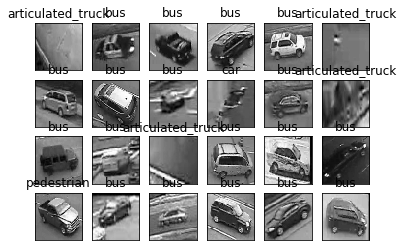

In [14]:
import matplotlib.pyplot as plt

# if you dont have this file yet
test_data = process_test_data()

# if you already have it
# test_data = np.load('test_data.npy')

plt.tight_layout()

fig = plt.figure()

for num, data in enumerate(test_data[:24]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,6,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    str_label = get_label(np.argmax(model_out))
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.margins(0.1, 0.5)
    
plt.show()

In [15]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [16]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 129795/129795 [01:44<00:00, 1239.34it/s]
